## install packages

In [ ]:
!apt install musescore fluidsynth
!pip install music21 pyFluidSynth
!pip install pretty_midi

!git clone https://github.com/ruiguo-bio/colab_tension_vae.git

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fluidsynth is already the newest version (1.1.9-1).
musescore is already the newest version (2.1.0+dfsg3-3build1).
0 upgraded, 0 newly installed, 0 to remove and 6 not upgraded.
Cloning into 'colab_tension_vae'...
remote: Enumerating objects: 23, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 23 (delta 4), reused 21 (delta 2), pack-reused 0
Unpacking objects: 100% (23/23), done.


In [ ]:
cd colab_tension_vae/

/content/colab_tension_vae


In [ ]:
import build_model
import util
import preprocess_midi

import pickle
import IPython.display as ipd
import os
import pretty_midi
import numpy as np
from google.colab import files

In [ ]:
util.setup_musescore()

## Load model and tension feature vectors

In [ ]:
model = build_model.build_model()

In [ ]:
model.load_weights('model/vae.h5')

In [ ]:
tensile_up_feature_vector = pickle.load(open('model/tensile_up_feature_vector','rb'))
diameter_up_feature_vector = pickle.load(open('model/diameter_up_feature_vector','rb'))

tensile_high_feature_vector = pickle.load(open('model/tensile_high_feature_vector','rb'))
diameter_high_feature_vector = pickle.load(open('model/diameter_high_feature_vector','rb'))

tensile_up_down_feature_vector = pickle.load(open('model/tensile_up_down_feature_vector','rb'))


## select midi file

In [ ]:

#@title # choose a midi file
#@markdown You can choose one of the examples provided here or upload your own midi file. If you upload your own file please make sure that the first track is melody and second track is bass, and the midi should be in C major or A minor.


def upload_midi():
    data = files.upload()
    if len(list(data.keys())) > 1:
        print('Multiple files uploaded; using only one.')
      
    return list(data.keys())[0]


melody = 'example1'  #@param ['example1','example2', 'Upload your midi']

if melody == 'Upload your midi':
    melody_file = upload_midi()
elif melody == 'example1':
    melody_file = 'data/268cce92d94088c1a724f4b609c9474c.mid'
else:
    melody_file = 'data/e6a4afe05f022c891bfe081d4be261db.mid'





  


## show the score and play 

In [ ]:
piano_roll, bar_indices = preprocess_midi.preprocess(melody_file)
piano_roll_new = np.reshape(piano_roll,(-1,piano_roll.shape[-1]))
pm_new = util.roll_to_pretty_midi(piano_roll_new)
util.show_score(pm_new)
ipd.Audio(pm_new.fluidsynth(fs=16000), rate=16000)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# print(f'there are {len(bar_indices)} valid 4 bar sections in the midi file')
# for i,indices in enumerate(bar_indices):
#     print(f'number,\t start,\t end')
#     print(f'{i+1}\t{indices[0]}\t {indices[1]}')



## tension manipulation

In [ ]:
#@title Please select start and end bar
#@markdown the selected bar length should be 4 bar or 8 bar

start_section = 4 #@param {type:"integer"}
end_section = 16 #@param {type:"integer"}



In [ ]:
#@title select the tension manipulation
#@markdown first 4 bar


tensile_strain_direction1 = True #@param ["False", "True"] {type:"raw"}
tensile_strain_factor1 = 7 #@param {type:"slider", min:-8, max:8, step:0.5}

diameter_level1 = True #@param ["False", "True"] {type:"raw"}
diameter_factor1 = 4 #@param {type:"slider", min:-4, max:4, step:0.5}

#@markdown second 4 bar (optional)

tensile_strain_direction2 = True #@param ["False", "True"] {type:"raw"}
tensile_strain_factor2 = -7 #@param {type:"slider", min:-8, max:8, step:0.5}

diameter_level2 = True #@param ["False", "True"] {type:"raw"}
diameter_factor2 = -3.5 #@param {type:"slider", min:-4, max:4, step:0.5}



### Run this to apply tension change to the seleted bars

first four bar tension


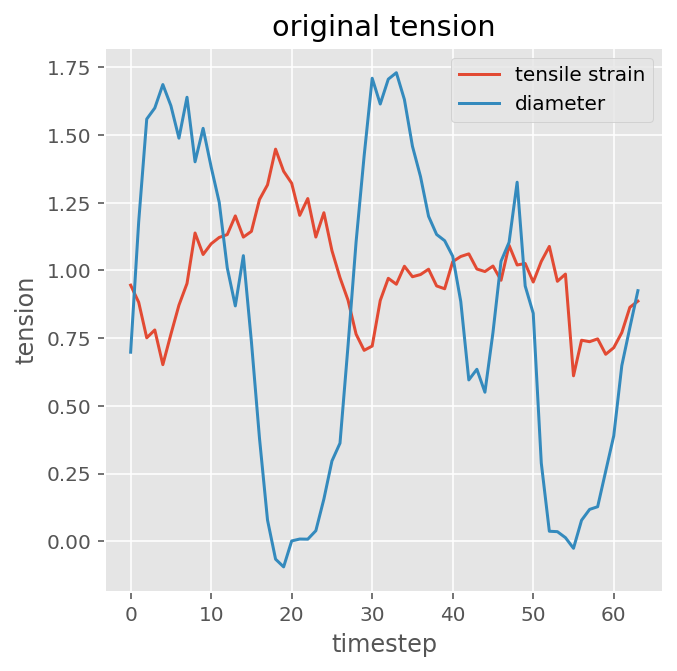

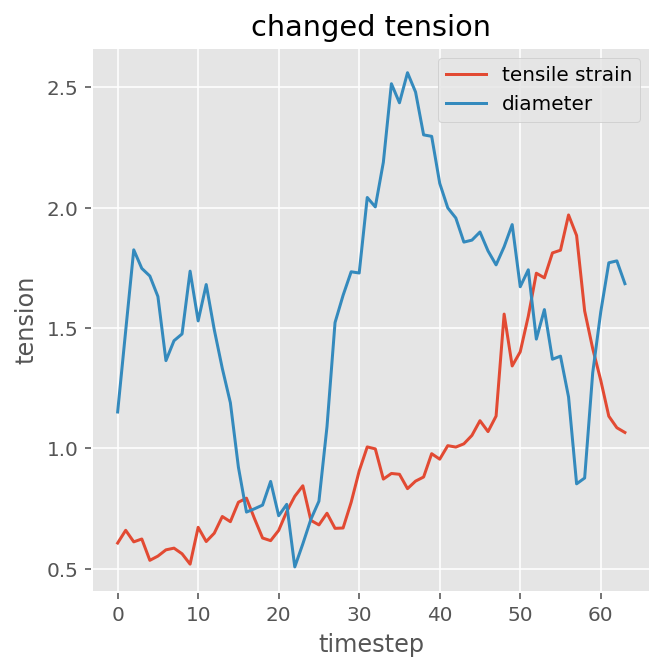

second four bar tension


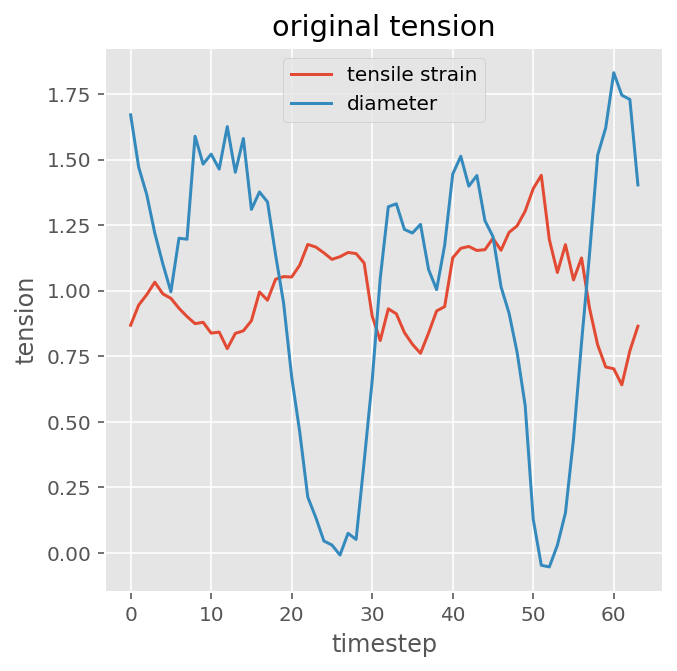

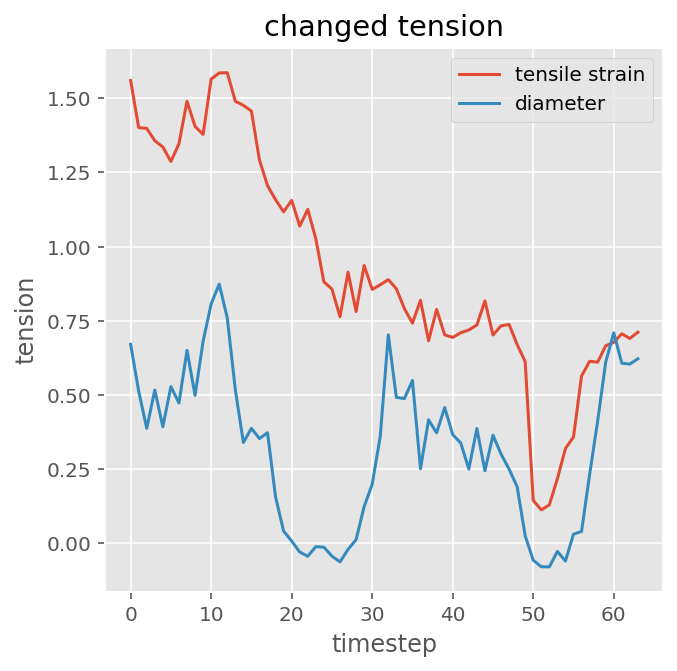

original score


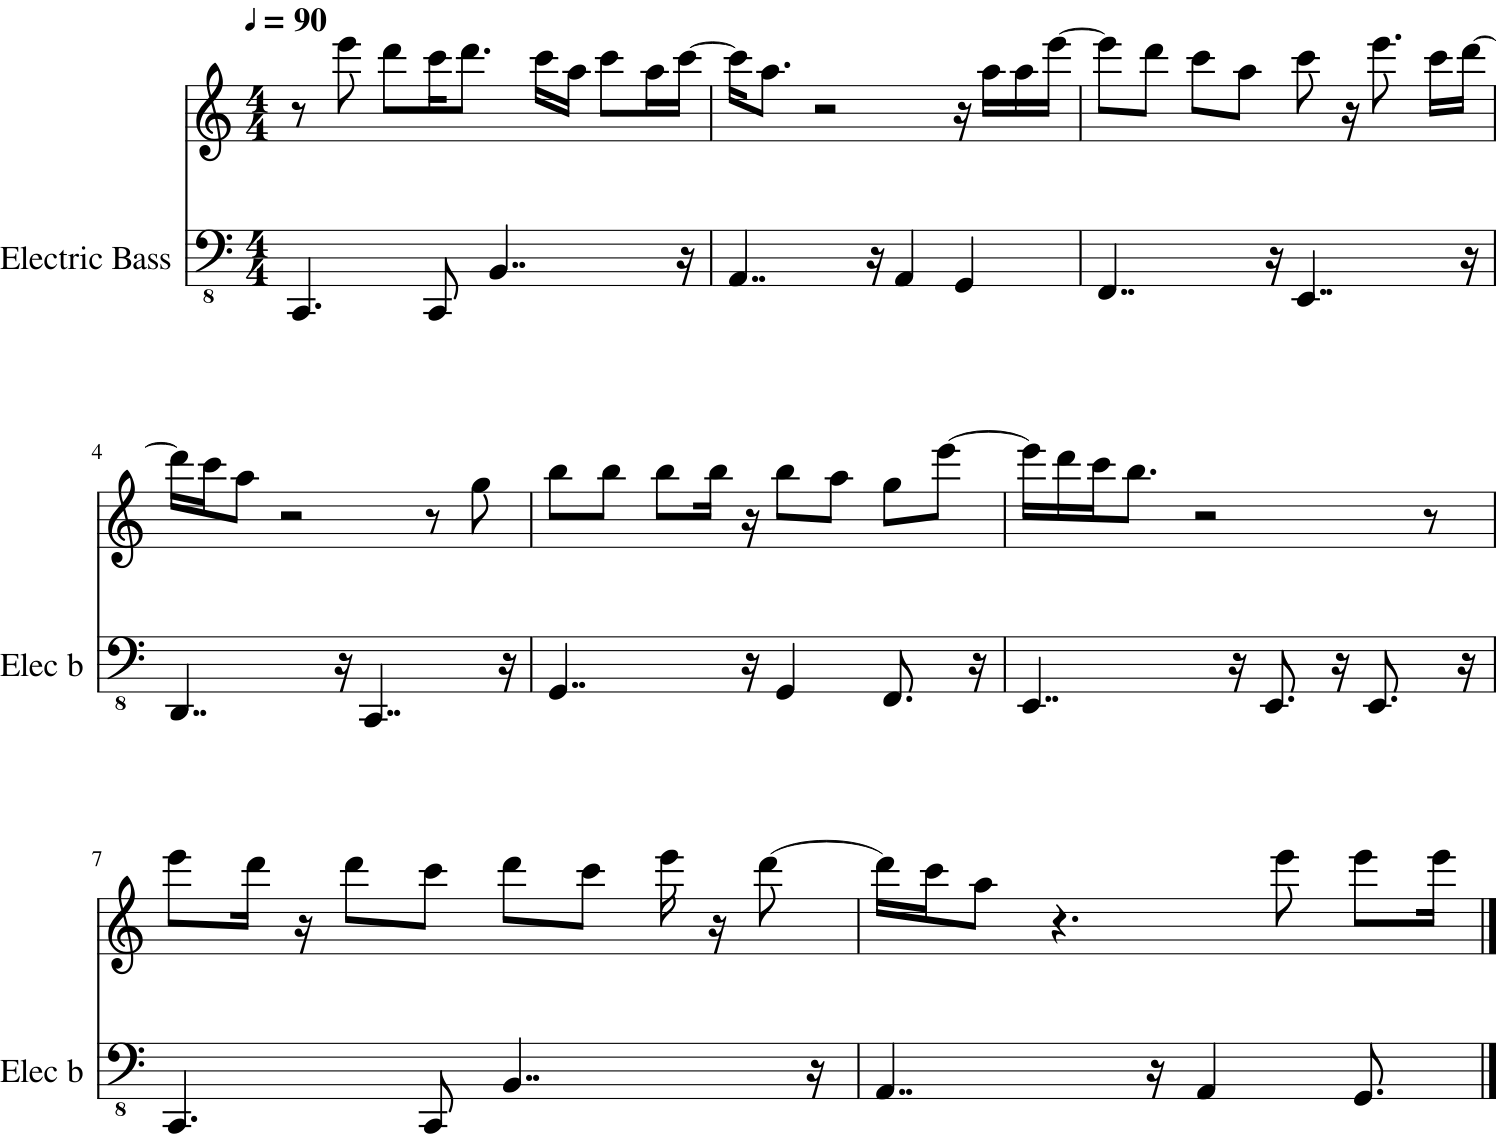

new score


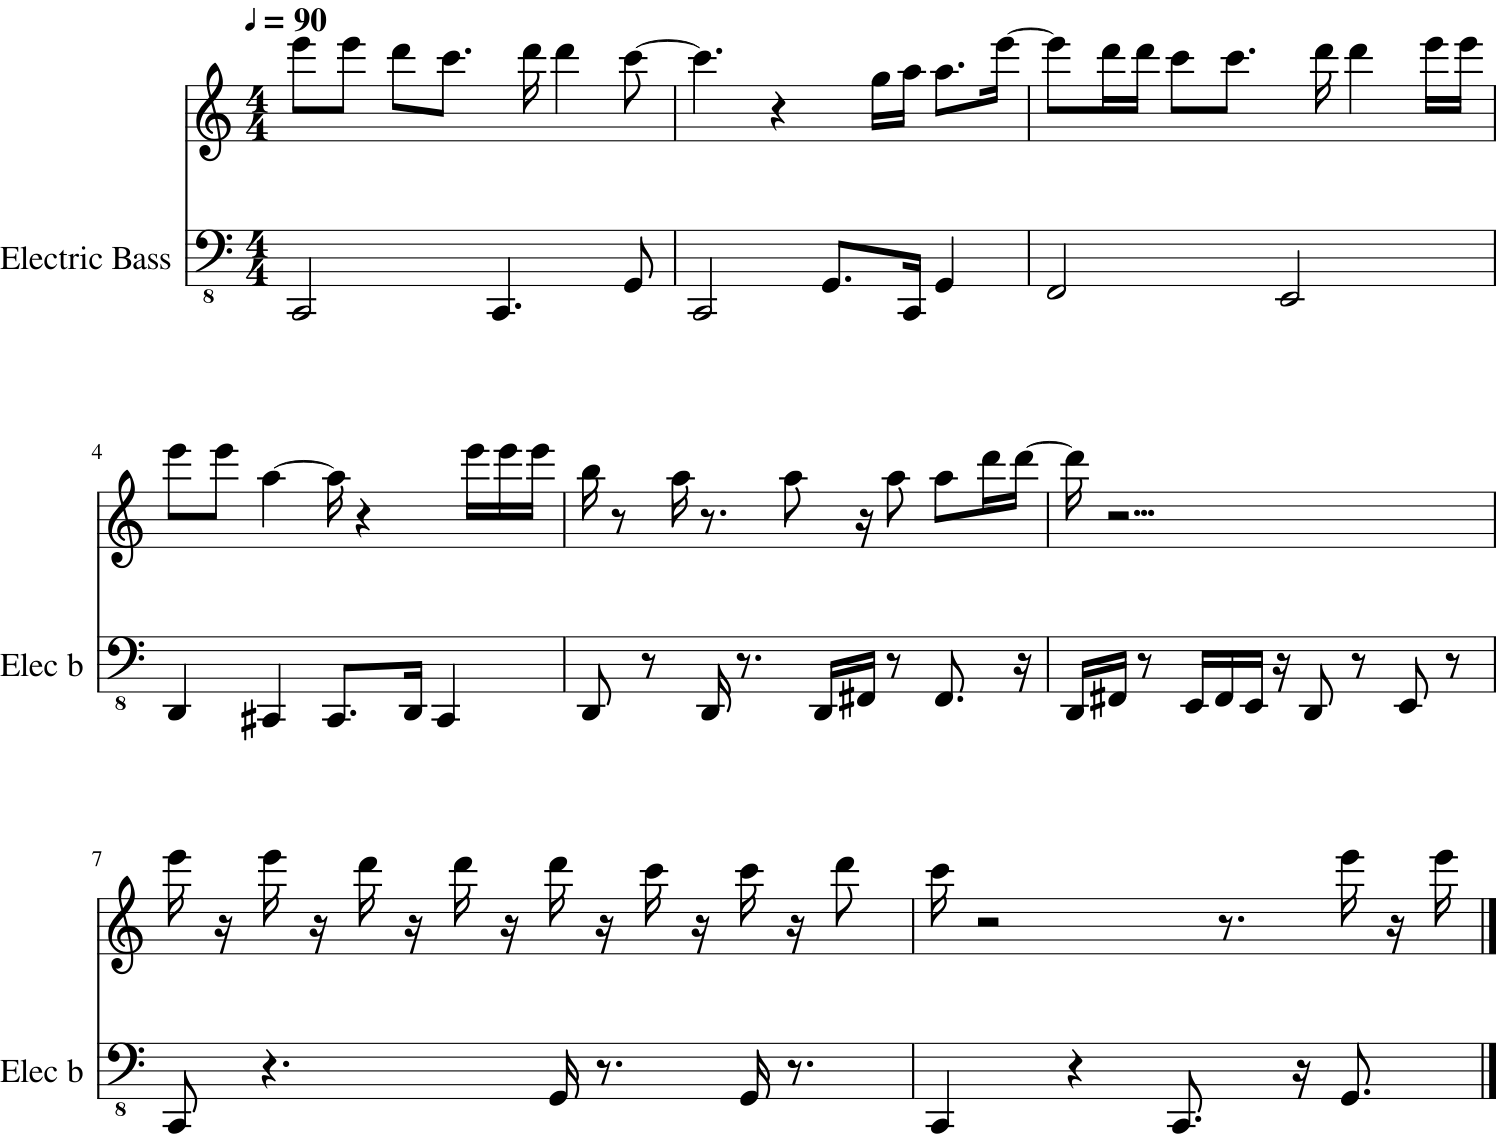

In [ ]:

selected_roll1 = piano_roll_new[16*(start_section-1):16*(start_section + 4-1)]
print('first four bar tension')
_,result_roll1 = build_model.manipuate_latent_space(selected_roll1,tensile_up_feature_vector,
                                    diameter_high_feature_vector,
                                    tensile_up_down_feature_vector,
                                    model,tensile_strain_factor1,
                                    diameter_factor1,0,
                                    tensile_strain_direction1,diameter_level1,False,
                                    True,True)



if end_section-start_section>4:
    selected_roll2 = piano_roll_new[16*(start_section + 3):16*(end_section-1)]
    print('second four bar tension')
    _,result_roll2 = build_model.manipuate_latent_space(selected_roll2,tensile_up_feature_vector,
                                    diameter_high_feature_vector,
                                    tensile_up_down_feature_vector,
                                    model,tensile_strain_factor2,
                                    diameter_factor2,0,
                                    tensile_strain_direction2,diameter_level2,False,
                                    True,True)


    result_roll = np.vstack([result_roll1,result_roll2])
    original_roll = piano_roll_new[16*(start_section-1):16*(end_section-1)]
else:
    result_roll = result_roll1
    original_roll = selected_roll1



pm_original = util.roll_to_pretty_midi(original_roll)
pm_new = util.roll_to_pretty_midi(result_roll)
print('original score')
util.show_score(pm_original)
print('new score')
util.show_score(pm_new)

        



### original music

In [ ]:
ipd.Audio(pm_original.fluidsynth(fs=16000), rate=16000)



changed music

In [ ]:
ipd.Audio(pm_new.fluidsynth(fs=16000), rate=16000)